# Experimenting with hardware

Running other circuits and ideas on hardware, since basic VQE with UCCSD doesn't work


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator
from datetime import datetime


## Hardware settings, path to HEA

In [6]:
backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting backend")

Done getting backend


In [6]:
print(backend.configuration().coupling_map)
print(backend.configuration().basis_gates)

[[1, 0], [2, 1], [3, 2], [4, 3], [4, 5], [4, 15], [6, 5], [6, 7], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [12, 17], [13, 12], [14, 0], [14, 18], [15, 22], [16, 8], [16, 26], [17, 30], [18, 19], [20, 19], [20, 33], [21, 20], [21, 22], [22, 23], [24, 23], [24, 34], [25, 24], [26, 25], [27, 26], [28, 27], [28, 29], [28, 35], [30, 29], [30, 31], [31, 32], [32, 36], [33, 39], [34, 43], [35, 47], [36, 51], [37, 38], [39, 38], [40, 39], [40, 41], [41, 53], [42, 41], [42, 43], [43, 44], [44, 45], [46, 45], [46, 47], [48, 47], [48, 49], [50, 49], [50, 51], [52, 37], [52, 56], [53, 60], [54, 45], [54, 64], [55, 49], [55, 68], [56, 57], [57, 58], [58, 59], [58, 71], [59, 60], [60, 61], [62, 61], [62, 63], [62, 72], [63, 64], [65, 64], [65, 66], [67, 66], [67, 68], [69, 68], [69, 70], [73, 66], [74, 70], [74, 89], [75, 90], [76, 75], [77, 71], [77, 76], [77, 78], [79, 78], [79, 80], [80, 81], [81, 72], [81, 82], [82, 83], [83, 92], [84, 83], [85, 73], [85, 84], [85, 86], [86, 87], [87, 88], [

In [7]:
backend2_name = "ibm_sherbrooke"
backend2 = service.backend(backend2_name)
print("Done getting backend2")
print(backend2.configuration().coupling_map)
print(backend2.configuration().basis_gates)

Done getting backend2
[[1, 0], [1, 2], [3, 2], [4, 3], [4, 15], [5, 4], [6, 5], [7, 6], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [12, 13], [14, 0], [14, 18], [16, 8], [17, 12], [17, 30], [18, 19], [19, 20], [20, 33], [21, 20], [21, 22], [22, 15], [23, 22], [23, 24], [25, 24], [26, 16], [26, 25], [26, 27], [28, 27], [29, 28], [29, 30], [31, 30], [31, 32], [32, 36], [33, 39], [34, 24], [35, 28], [35, 47], [36, 51], [37, 38], [38, 39], [40, 39], [41, 40], [41, 53], [42, 41], [43, 34], [43, 42], [43, 44], [45, 44], [45, 46], [47, 46], [47, 48], [49, 48], [49, 50], [50, 51], [52, 37], [53, 60], [54, 45], [55, 49], [56, 52], [56, 57], [57, 58], [59, 58], [59, 60], [61, 60], [61, 62], [63, 62], [63, 64], [64, 54], [64, 65], [66, 65], [67, 66], [68, 55], [68, 67], [69, 68], [69, 70], [71, 58], [71, 77], [72, 62], [73, 66], [73, 85], [74, 70], [75, 76], [77, 76], [78, 77], [78, 79], [79, 91], [80, 79], [80, 81], [81, 72], [81, 82], [82, 83], [83, 84], [85, 84], [86, 85], [86, 87], [87, 88],

## Information about hardware properties

Coupling map - shows which qubits can directly interact with 2-qubit gates (e.g. CNOT or ECR)

|Gate | Meaning | Notes|
|---|---|---|
|ecr | Echoed Cross-Resonance (2-qubit) | Native IBM entangling gate (like a cleaner CNOT)|
|id | Identity (1-qubit) | Does nothing; used for scheduling/padding|
|rz | $R_z(\theta)$ | Z-axis rotation; cheap on IBM (virtual gate)|
|sx | Square-root of X gate | $ \sqrt{X} $, needed for universal control|
|x | Pauli-X (NOT gate) | Flips qubit state $|
> Table from ChatGPT

## Qubit hamiltonian

Qubit hamiltonian generated by PySCFDriver on $H_2$ molecule (with 0.735A distance), sto-3g basis, Jordan-Wigner mapper

In [8]:
qubit_hamiltonian=SparsePauliOp(['IIII', 'IIIZ', 'IIZZ', 'IIZI', 'IZZI', 'IZZZ', 'ZZII', 'ZZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'IZIZ', 'ZZZZ', 'ZIZI'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j, -0.0452328 +0.j, -0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])

## Ansatz for $H_2$ example

Straight from the https://pmc.ncbi.nlm.nih.gov/articles/PMC9979602/ 3.1. section.

Some help from chatGPT. $H_2$ Hamiltonian (from papers, parity mapping):

$$
\hat{H}_q = c_0 I \otimes I + c_1 Z \otimes I + c_2 I \otimes Z + c_3 Z \otimes Z + c_4 X \otimes X
$$

here, $c_0$ through $c_4$ are real coefficients that depend on the specific bond length of the H–H molecule.

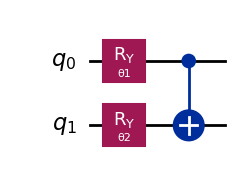

In [3]:
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')

ansatz = QuantumCircuit(2)
ansatz.ry(theta1, 0)
ansatz.ry(theta2, 1)
ansatz.cx(0, 1)
ansatz.draw("mpl")


In [4]:
# 0.735A

coeffs = np.array([
    -1.052373245772859,  # I I
     0.39793742484318045,  # Z I
    -0.39793742484318045,  # I Z
    -0.01128010425623538,  # Z Z
     0.18093119978423156   # X X
])

paulis = ['II', 'ZI', 'IZ', 'ZZ', 'XX']

hamiltonian = SparsePauliOp(paulis, coeffs)

Initial Energy: -1.0636533500290943

RESULTS:
Optimal Parameters: [-1.  0.]
Optimal Energy: -1.215901704894006


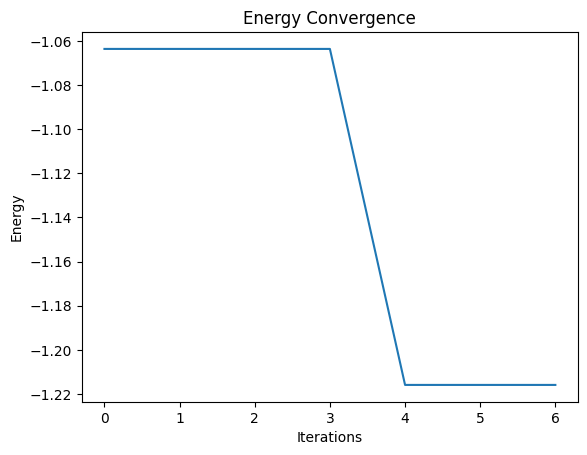

In [ ]:
# SIMULATOR
optimizer = L_BFGS_B(maxfun=1, maxiter=1, iprint=100) ######## ITERATION LIMIT DOESNT WORK
initial_point = np.zeros(ansatz.num_parameters)
estimator = StatevectorEstimator()
results = []

def estimate_energy(parameters):
    job = estimator.run(
        [(ansatz, hamiltonian, parameters)]
    )
    result = job.result()[0].data.evs
    results.append(result)
    return result

print("Initial Energy:", estimate_energy(initial_point))

result = optimizer.minimize(fun=estimate_energy, x0=initial_point)

print("\nRESULTS:")
print("Optimal Parameters:", result.x)
print("Optimal Energy:", result.fun)

plt.plot(results)
plt.xlabel('Iterations')
plt.xticks(range(len(results)))
plt.ylabel('Energy')
plt.title('Energy Convergence')
plt.show()

In [ ]:
# HARDWARE
optimizer = L_BFGS_B(maxfun=3)  ########### ITERATION LIMIT DOESNT WORK
initial_point = np.zeros(ansatz.num_parameters)
results = []

ansatz = transpile(
    [ansatz],
    optimization_level=1,
    backend=backend,
)[0]

hamiltonian = hamiltonian.apply_layout(ansatz.layout)

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"

def estimate_energy(parameters):
    job = estimator.run(
        [(ansatz, hamiltonian, parameters)]
    )
    print(f"{datetime.now()} Job submitted: {job.job_id()}")

    result = job.result()[0].data.evs
    results.append(result)
    return result

print(f"{datetime.now()} Result: {estimate_energy(initial_point)}")

result = optimizer.minimize(fun=estimate_energy, x0=initial_point)

2025-04-24 00:09:55.614106 Job submitted: d04pachnhqag008nz9sg
2025-04-24 00:09:52.668998 Result: -1.0734811755035094
2025-04-24 00:10:20.979900 Job submitted: d04pak2rxz8g008815xg
2025-04-24 00:10:45.704206 Job submitted: d04pas3qnmvg0084cpj0
2025-04-24 00:11:11.468101 Job submitted: d04pazkrxz8g0088160g
2025-04-24 00:11:36.391505 Job submitted: d04pb5wrxz8g00881620
2025-04-24 00:12:18.947810 Job submitted: d04pbged8drg008qwvp0
2025-04-24 00:13:03.158652 Job submitted: d04pbvfnhqag008nza60
2025-04-24 00:13:46.294869 Job submitted: d04pc68nhqag008nza9g
2025-04-24 00:14:11.433238 Job submitted: d04pcchkzhn0008w7rr0


KeyboardInterrupt: 


RESULTS:
Optimal Parameters: [-1.57079628  0.        ]
Optimal Energy: -1.2445845498133257


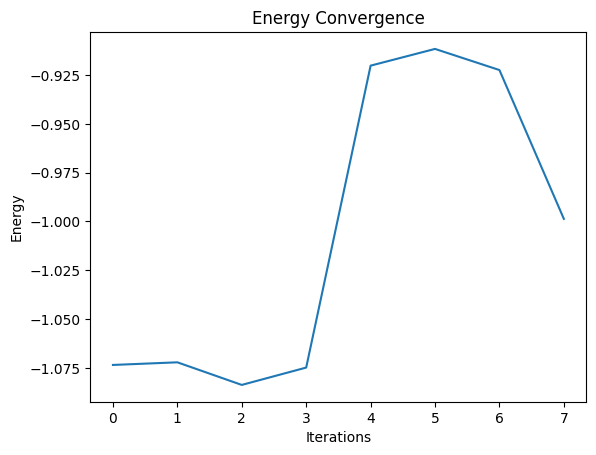

In [29]:
print("\nRESULTS:")
print("Optimal Parameters:", result.x)
print("Optimal Energy:", result.fun)

plt.plot(results)
plt.xlabel('Iterations')
plt.xticks(range(len(results)))
plt.ylabel('Energy')
plt.title('Energy Convergence')
plt.show()

In [ ]:
job1 = service.job("d04pak2rxz8g008815xg")
print(job1.metrics())

{'bss': {'seconds': 13}, 'usage': {'quantum_seconds': 13, 'seconds': 13}, 'timestamps': {'created': '2025-04-23T22:10:20.281Z', 'finished': '2025-04-23T22:10:42.248Z', 'running': '2025-04-23T22:10:23.035Z'}, 'executions': 0, 'num_circuits': 0, 'num_qubits': None, 'circuit_depths': None, 'qiskit_version': 'qiskit_ibm_runtime-0.34.0,qiskit-1.3.1*,qiskit_aer-0.16.1*,qiskit_nature-0.7.2,qiskit_optimization-0.6.1', 'estimated_start_time': '2025-04-23T22:10:21.454Z', 'estimated_completion_time': '2025-04-23T22:10:34.454Z', 'position_in_queue': None, 'position_in_provider': None}
